In [1]:
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
stock_name = ['AAPL','CSCO','IBM','AMZN']
port = ['AAPL','CSCO','IBM','AMZN']

In [3]:
start = datetime.datetime(2019,1,1)
end = datetime.datetime(2020,1,1)

def sto_pri(x):
    data = pdr.get_data_yahoo(x,start,end)
    data = data['Adj Close']
    return data

data = pd.DataFrame({stock_name[0]:sto_pri(port[0]),
 stock_name[1]:sto_pri(port[1]),
 stock_name[2]:sto_pri(port[2]),
 stock_name[3]:sto_pri(port[3])
})

# data = pd.DataFrame({stock_name[0]:sto_pri(port[0]),
#  stock_name[1]:sto_pri(port[1]),
#  stock_name[2]:sto_pri(port[2]),
#  stock_name[3]:sto_pri(port[3]),
#  stock_name[4]:sto_pri(port[4]),
#  stock_name[5]:sto_pri(port[5]),
#  stock_name[6]:sto_pri(port[6])
# })

data = data.dropna()
print(data.head(8))
#returns = data.pct_change(-1).dropna()
log_returns = np.log(data/data.shift(1)).dropna()
print(log_returns.head(8))
# print(returns.cov())

                 AAPL       CSCO         IBM         AMZN
Date                                                     
2018-12-31  38.461140  40.411636  101.703552  1501.969971
2019-01-02  38.505024  40.057236  103.081429  1539.130005
2019-01-03  34.669640  38.600437  101.023560  1500.280029
2019-01-04  36.149662  40.339195  104.969307  1575.390015
2019-01-07  36.069202  40.611755  105.711922  1629.510010
2019-01-08  36.756794  40.940712  107.215065  1656.579956
2019-01-09  37.380985  40.715141  107.984528  1659.420044
2019-01-10  37.500465  40.639957  108.968719  1656.219971
                AAPL      CSCO       IBM      AMZN
Date                                              
2019-01-02  0.001140 -0.008808  0.013457  0.024440
2019-01-03 -0.104924 -0.037046 -0.020165 -0.025566
2019-01-04  0.041803  0.044060  0.038314  0.048851
2019-01-07 -0.002228  0.006734  0.007050  0.033776
2019-01-08  0.018884  0.008067  0.014119  0.016476
2019-01-09  0.016839 -0.005525  0.007151  0.001713
2019-01-10  

In [4]:
np.random.seed(123)
num_ports = 10
all_weights = np.zeros((num_ports, len(stock_name)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(stock_name)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_returns.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [5]:
print('sharpe ratio max: {}'.format(sharpe_arr.max()))
print('sharpe ratio argmax: {}'.format(sharpe_arr.argmax()))
print('sample weights: {}'.format(all_weights[sharpe_arr.argmax(),:]))

sharpe ratio max: 1.9347200364463293
sharpe ratio argmax: 6
sample weights: [0.44173869 0.19747353 0.22121601 0.13957177]


In [6]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

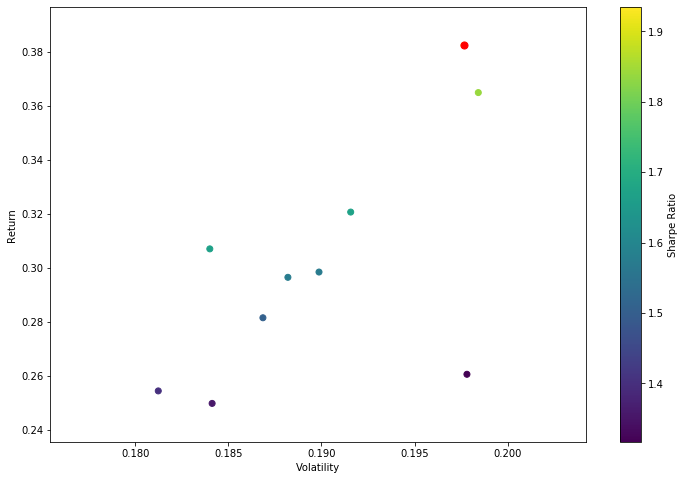

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# plt.xlim(0.15,0.25)
# plt.ylim(-0.5,1.)
plt.savefig('best_sr.png')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

In [8]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [9]:
cons = ({'type':'eq','fun':check_sum})
bounds = tuple((0,1) for i in range(len(stock_name)))
ini_guess = list(np.ones(len(stock_name))*(1/len(stock_name)))

In [10]:
optimal_results = opt.minimize(neg_sharpe, ini_guess, method = 'SLSQP', bounds = bounds, constraints = cons)

In [11]:
print(optimal_results)

     fun: -2.4198724493339547
     jac: array([2.98023224e-08, 7.04439253e-01, 5.80507517e-02, 4.49213415e-01])
 message: 'Optimization terminated successfully.'
    nfev: 12
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1., 0., 0., 0.])


In [12]:
get_ret_vol_sr(optimal_results.x)

array([0.63635373, 0.26296995, 2.41987245])

In [13]:
frontier_y = np.linspace(0.2,0.6,50)
def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = opt.minimize(minimize_vol,ini_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

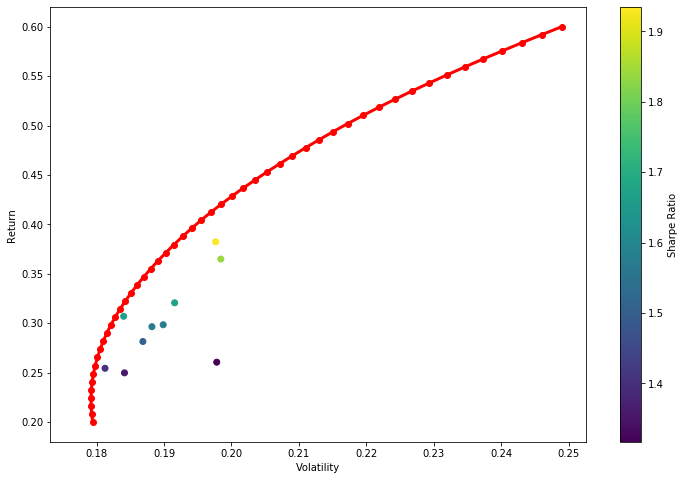

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r-o', linewidth=3)
plt.savefig('cover.png')
plt.show()